# **Energy Demand Forecasting for Cali with an LSTM Model**

In this notebook, we will develop a forecasting model for the daily energy demand in the city of Cali. We will use historical data from the Colombian electricity market, provided by XM, and build a neural network of type LSTM (Long Short-Term Memory), ideal for analyzing sequences and time series.

The objective is to create a model able of learning from historical patterns, including trends, seasonality and holiday effects, to accurately predict future energy demand.

First, we set up the working environment by adding the source directory to the Python path and importing the specific modules needed for this project.

* **Project modules**:

    * `data_loader.fetch_xm_data_range`: For downloading data from the XM API within a specific date range.

    * `processing`: Contains functions for data loading and cleaning (`load_and_clean_data`), feature engineering (`create_features`, `create_lag_features`), data scaling (`scale_data`), sequence creation for LSTM (`create_sequences`), and smoothing (`apply_moving_average`).

    * `lstm_model.LSTMModel`: Defines the LSTM neural network architecture.

    * `train.train_model`: Contains the model training loop.

    * `evaluate`: Includes functions for model evaluation (`evaluate_model`), metrics saving (`save_metrics`), and prediction visualization (`plot_predictions`).

    * `utils`: Utility functions for PyTorch predictions (`predict_pytorch`), data splitting (`split_train_val`), and inverse scaling (`desescalar_y`).

In [ ]:
import sys
import os
sys.path.append('../src')

In [ ]:
from data_loader import fetch_xm_data_range
from processing import load_and_clean_data, create_features, create_lag_features, scale_data, create_sequences, apply_moving_average
from lstm_model import LSTMModel
from train import train_model
from evaluate import evaluate_model, save_metrics, plot_predictions
from utils import predict_pytorch, split_train_val, desescalar_y

## **2. Data Acquisition**

We download historical energy demand data for the Cali market (`MC-Cali`) using the `fetch_xm_data_range` function. A date range from January 2022 to January 2025 is specified to obtain an extensive historical record. The data is saved locally in a CSV file for subsequent use.



In [ ]:
# Descarga los datos (si es necesario)
fetch_xm_data_range(
    dataset_id='9e9ee7',
    start_date='2022-01-01',
    end_date='2025-01-01',
    city='MC-Cali',
    save_path='../data/xm_api_data.csv'
)



Descargando datos de 2021-01-01 a 2021-01-31...
No se encontraron registros para 2021-01-01 a 2021-01-31.
Descargando datos de 2021-02-01 a 2021-02-28...
No se encontraron registros para 2021-02-01 a 2021-02-28.
Descargando datos de 2021-03-01 a 2021-03-31...
No se encontraron registros para 2021-03-01 a 2021-03-31.
Descargando datos de 2021-04-01 a 2021-04-30...
No se encontraron registros para 2021-04-01 a 2021-04-30.
Descargando datos de 2021-05-01 a 2021-05-31...
No se encontraron registros para 2021-05-01 a 2021-05-31.
Descargando datos de 2021-06-01 a 2021-06-30...
No se encontraron registros para 2021-06-01 a 2021-06-30.
Descargando datos de 2021-07-01 a 2021-07-31...
No se encontraron registros para 2021-07-01 a 2021-07-31.
Descargando datos de 2021-08-01 a 2021-08-31...
No se encontraron registros para 2021-08-01 a 2021-08-31.
Descargando datos de 2021-09-01 a 2021-09-30...
No se encontraron registros para 2021-09-01 a 2021-09-30.
Descargando datos de 2021-10-01 a 2021-10-31..

,Fecha,Periodo,CodigoDuracion,MercadoComercializacionOperativo,DemandaAtendida,PronDem
0,2022-01-31,1,PT1H,MC-Cali,359265.19,389969.41
1,2022-01-31,2,PT1H,MC-Cali,348388.19,372041.03
2,2022-01-31,3,PT1H,MC-Cali,349952.53,359748.38
3,2022-01-31,4,PT1H,MC-Cali,345523.28,355477.72
4,2022-01-31,5,PT1H,MC-Cali,349821.84,360858.81
...,...,...,...,...,...,...
26323,2025-01-01,20,PT1H,MC-Cali,379179.54,363277.40
26324,2025-01-01,21,PT1H,MC-Cali,370403.14,349329.90
26325,2025-01-01,22,PT1H,MC-Cali,354292.65,329162.10
26326,2025-01-01,23,PT1H,MC-Cali,333373.18,308425.00


## **3. Data Preprocessing and Feature Engineering**

This is a crucial step where we transform the raw data into a suitable format for the LSTM model.

1. **Loading and Cleaning**: We load the data from the CSV file. The `load_and_clean_data` function handles data type adjustments, missing value management, and aggregates the data to daily frequency, creating the target variable `Demanda_MWh`.

2. **Moving Average**: We apply a moving average (`apply_moving_average`) to smooth the time series and help the model capture the underlying trend.

3. **Feature Engineering**: We create new features (`create_features`) from the date so the model can identify temporal patterns:

   * **Cyclic Features**: Day of year, day of week, and month. These are transformed using sine and cosine so the model understands their cyclic nature (for example, that day 365 is close to day 1).

   * **Holidays**: A boolean feature (`es_festivo`) is added that indicates whether a day is a holiday in Colombia, as these days have atypical consumption patterns. The `holidays` library is used for this purpose.

4. **Lag Features**: We create lag features (`create_lag_features`) for 1, 7, and 14 days. These are the demand values from previous days and are fundamental for the model to learn the autocorrelation of the series.

5. **Data Scaling**: We scale all features to a range of [0, 1] using `MinMaxScaler` from Scikit-learn. This step is essential for neural networks to converge more quickly and stably.

In [ ]:
df = load_and_clean_data('../data/xm_api_data.csv')
df = apply_moving_average(df)
df = create_features(df)
df = create_lag_features(df, lags=[1, 7, 14], target_col='Demanda_MWh')
df_scaled, scaler = scale_data(df, target_col='Demanda_MWh')

Next, we visualize the result of the preprocessing, showing the shape and the first rows of the DataFrames, both the original and the scaled one.

In [ ]:
print("Shape del DataFrame final:", df.shape)
print("Primeras filas del DataFrame procesado:")
display(df.head())

print("\nShape del DataFrame escalado:", df_scaled.shape)
print("Primeras filas del DataFrame escalado:")
display(df_scaled.head())

print("\nColumnas del DataFrame procesado:", df.columns.tolist())
print("Filas en df_scaled:", df_scaled.shape[0])

Shape del DataFrame final: (1083, 15)
Primeras filas del DataFrame procesado:


,Demanda_MWh,PronDem_MWh,DayOfYear,sin_dia,cos_dia,DayOfWeek,sin_semana,cos_semana,Month,sin_mes,cos_mes,es_festivo,lag_1,lag_7,lag_14
Fecha,,,,,,,,,,,,,,,
2022-01-15,422.793537,427.857142,15,0.255182,0.966893,5,-0.974928,-0.222521,1,0.5,0.866025,0,416.638471,397.320594,304.306402
2022-01-16,428.168157,429.642857,16,0.271777,0.962360,6,-0.781831,0.623490,1,0.5,0.866025,0,422.793537,400.762660,317.055063
2022-01-17,444.561360,439.113094,17,0.288291,0.957543,0,0.000000,1.000000,1,0.5,0.866025,0,428.168157,395.573653,343.875107
2022-01-18,453.095142,438.345237,18,0.304719,0.952442,1,0.781831,0.623490,1,0.5,0.866025,0,444.561360,396.568904,361.604284
2022-01-19,459.745889,437.958333,19,0.321058,0.947060,2,0.974928,-0.222521,1,0.5,0.866025,0,453.095142,402.082292,372.579765



Shape del DataFrame escalado: (1083, 15)
Primeras filas del DataFrame escalado:


,Demanda_MWh,PronDem_MWh,DayOfYear,sin_dia,cos_dia,DayOfWeek,sin_semana,cos_semana,Month,sin_mes,cos_mes,es_festivo,lag_1,lag_7,lag_14
Fecha,,,,,,,,,,,,,,,
2022-01-15,0.265857,0.277483,0.038356,0.627596,0.983451,0.833333,0.000000,0.356896,0.0,0.75,0.933013,0.0,0.230072,0.117760,0.000000
2022-01-16,0.297104,0.289471,0.041096,0.635893,0.981185,1.000000,0.099031,0.801938,0.0,0.75,0.933013,0.0,0.265857,0.137772,0.052086
2022-01-17,0.392412,0.353047,0.043836,0.644150,0.978776,0.000000,0.500000,1.000000,0.0,0.75,0.933013,0.0,0.297104,0.107603,0.161663
2022-01-18,0.442027,0.347892,0.046575,0.652364,0.976225,0.166667,0.900969,0.801938,0.0,0.75,0.933013,0.0,0.392412,0.113390,0.234097
2022-01-19,0.480694,0.345295,0.049315,0.660534,0.973534,0.333333,1.000000,0.356896,0.0,0.75,0.933013,0.0,0.442027,0.145444,0.278939



Columnas del DataFrame procesado: ['Demanda_MWh', 'PronDem_MWh', 'DayOfYear', 'sin_dia', 'cos_dia', 'DayOfWeek', 'sin_semana', 'cos_semana', 'Month', 'sin_mes', 'cos_mes', 'es_festivo', 'lag_1', 'lag_7', 'lag_14']
Filas en df_scaled: 1083


## **4. Sequence Preparation for the LSTM Model**

LSTM models require input data to be in sequence format. We use the `create_sequences` function to transform our DataFrame into sequences of a defined length (`sequence_length = 5`). Each input sequence (`X`) will contain data from 5 consecutive days, and the label (`y`) will be the demand for the following day.


In [ ]:
sequence_length = 5
X, y = create_sequences(df_scaled, target_col='Demanda_MWh', sequence_length=sequence_length)
print("Shape de X:", X.shape)

Shape de X: (1078, 5, 15)


## **5. Model Construction and Training**

### **Data Split**

We split our dataset into 80% for training (`X_train`, `y_train`) and 20% for testing (`X_test`, `y_test`). Subsequently, the training set is subdivided to create a validation set, which will help us monitor overfitting.

In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print("Shape de X_train:", X_train.shape)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

Shape de X_train: (862, 5, 15)


### **Model Definition**

We instantiate our `LSTMModel` with the following architecture:

* `input_dim`: The number of input features (15).
* `hidden_dim`: 64 neurons in the hidden layers.
* `num_layers`: 3 stacked LSTM layers.
* `output_dim`: 1, since we predict a single value (demand).

In [ ]:
input_dim = X_train.shape[2]  # número de features
hidden_dim = 64               # puedes ajustar este valor
num_layers = 3                # puedes ajustar este valor
output_dim = 1

model_2 = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

Before training, we separated 20% of the training set to use as a validation set.

In [ ]:
X_train_final, X_val, y_train_final, y_val = split_train_val(X_train, y_train, val_size=0.2)

### **Training**

We train the model with the training and validation data. We use an **early stopping** technique with a patience of 10 epochs. This means that training will stop if the loss in the validation set does not improve for 10 consecutive epochs, thus avoiding overfitting.

In [ ]:
modelo_entrenado, val_losses = train_model(
    model_2,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=200,
    batch_size=32,
    learning_rate=0.001,
    patience=10
)

Epoch [10/200], Loss: 0.0061, Val Loss: 0.0043
Epoch [20/200], Loss: 0.0037, Val Loss: 0.0023
Epoch [30/200], Loss: 0.0027, Val Loss: 0.0019
Epoch [40/200], Loss: 0.0017, Val Loss: 0.0007
Epoch [50/200], Loss: 0.0020, Val Loss: 0.0005
Epoch [60/200], Loss: 0.0007, Val Loss: 0.0005
Epoch [70/200], Loss: 0.0008, Val Loss: 0.0005
Early stopping en la época 71


## **6. Model Evaluation**

Once trained, we evaluate the model's performance on the test set, which contains data the model has never seen.

We calculate the following metrics:

* **RMSE (Root Mean Squared Error)**: Measures the root of the mean squared error.
* **MAE (Mean Absolute Error)**: Measures the mean absolute error.
* **R² (R-squared)**: Indicates what proportion of the variance in the dependent variable is predictable from the independent variables.

The results, such as the **R² of 0.966**, indicate that the model is capable of explaining 96.6% of the variability in energy demand, which is excellent performance.

In [ ]:
y_pred = predict_pytorch(model_2, X_test)

metrics = evaluate_model(model_2, X_test, y_test, scaler, target_col_index=df.columns.get_loc('Demanda_MWh'))
save_metrics(metrics, '../results/metrics.txt')
print(metrics)

{'rmse': np.float64(4.497918850098314), 'mae': 3.4649522267515804, 'r2': 0.9665166106291712}


### **Results Visualization**

Finally, for a more intuitive evaluation, we rescale the predictions and actual values to their original scale (MWh) and plot them. The graph shows that the LSTM model predictions closely follow the actual values, confirming its high accuracy.

In [ ]:
y_test_real = desescalar_y(scaler, y_test, target_col_index=df.columns.get_loc('Demanda_MWh'))
y_pred_real = desescalar_y(scaler, y_pred, target_col_index=df.columns.get_loc('Demanda_MWh'))
dates_test = df.index[-len(y_test):]

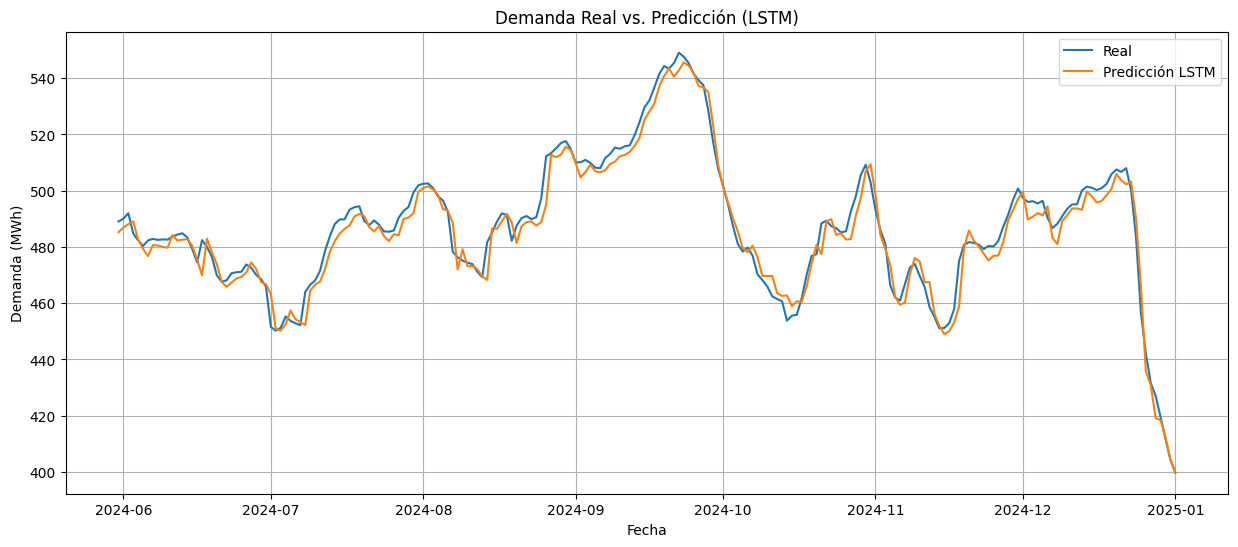

In [ ]:
plot_predictions(
    dates=dates_test,
    y_true=y_test_real,
    y_pred=y_pred_real,
    model_name="LSTM",
    filepath="../results/predicciones_lstm.png"
)